In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
np.set_printoptions(suppress=True)
sns.set(style='whitegrid')

In [10]:
train_path = './train.csv'
test_path = './test.csv'
train_data = pd.read_csv(train_path, index_col='Id')
test_data = pd.read_csv(test_path, index_col='Id')
features = train_data.iloc[:,:-1]
target = train_data.loc[:, ['SalePrice']]
print('Train Set Size : ', train_data.shape)
print('Test Set Size : ', test_data.shape)
print('Train Features Size : ', features.shape)
num_train_rows = train_data.shape[0]
num_test_rows = test_data.shape[0]
print('Train Rows : ', num_train_rows)
print('Test Rows : ', num_test_rows)

all_data = pd.concat((features, test_data)).reset_index(drop=True)

Train Set Size :  (1460, 80)
Test Set Size :  (1459, 79)
Train Features Size :  (1460, 79)
Train Rows :  1460
Test Rows :  1459


In [11]:
# Analyze SalePrice
print('Skewness of SalePrice before Log Transform : %f'% target.skew())
print('Kurtosis of SalePrice before Log Transform : %f'% target.kurt())

'''
Skew = 1.882876 indicates positive skew with tail to the right.
Kurt = 6.536282 indicates heavy tails i.e. more data on tails.
'''

#Apply Log transformation
target['SalePrice'] = np.log(target['SalePrice'])
print('Skewness of SalePrice after Log Transform : %f'% target.skew())
print('Kurtosis of SalePrice after Log Transform : %f'% target.kurt())

Skewness of SalePrice before Log Transform : 1.882876
Kurtosis of SalePrice before Log Transform : 6.536282
Skewness of SalePrice after Log Transform : 0.121335
Kurtosis of SalePrice after Log Transform : 0.809532


In [12]:
# Missing Data
null_features = all_data.columns[all_data.isnull().any()]
missing_ratio = (all_data[null_features].isnull().sum()/len(all_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
print(missing_data.sort_values(by='Missing Ratio',ascending=False))


for col in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
    all_data[col] = all_data[col].fillna('None')

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'MasVnrType']:
    all_data[col] = all_data[col].fillna('None')
    
for col in ['BsmtExposure', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']:
    all_data[col] = all_data[col].fillna('None')

'''
No GarageYrBlt means no Garage. We can impute mean/median since it would 
incorrectly convey existence of Garage. same reasoning for MasVnrArea.
'''
for col in ['GarageYrBlt', 'MasVnrArea']:
    all_data[col] = all_data[col].fillna(0)
    
'''
Group data by neighborhood & imputed null LotFrontage columns with median of
grouped data.
'''
all_data['LotFrontage'] = all_data.groupby(['Neighborhood'])\
                    ['LotFrontage'].transform(lambda x : x.fillna(x.median()))
    
all_data['Electrical'] = \
    all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
    
all_data['MSZoning'] = \
    all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
    
all_data['Utilities'] = all_data['Utilities'].fillna('ELO')

all_data['Exterior1st'] = all_data['Exterior1st'].fillna('Other')

all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('Other')

all_data['SaleType'] = all_data['SaleType'].fillna('Oth')

all_data['Functional'] = \
    all_data['Functional'].fillna(all_data['Functional'].mode()[0])

all_data['KitchenQual'] = \
    all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

for col in ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea']:
    all_data[col] = all_data[col].fillna(0)
    
null_features = all_data.columns[all_data.isnull().any()]
missing_ratio = (all_data[null_features].isnull().sum()/len(all_data)) * 100
missing_data = pd.DataFrame({'Missing Ratio' :missing_ratio})
print(missing_data.sort_values(by='Missing Ratio',ascending=False))

              Missing Ratio
PoolQC                99.66
MiscFeature           96.40
Alley                 93.22
Fence                 80.44
FireplaceQu           48.65
LotFrontage           16.65
GarageFinish           5.45
GarageQual             5.45
GarageCond             5.45
GarageYrBlt            5.45
GarageType             5.38
BsmtExposure           2.81
BsmtCond               2.81
BsmtQual               2.77
BsmtFinType2           2.74
BsmtFinType1           2.71
MasVnrType             0.82
MasVnrArea             0.79
MSZoning               0.14
BsmtFullBath           0.07
BsmtHalfBath           0.07
Functional             0.07
Utilities              0.07
GarageArea             0.03
GarageCars             0.03
Electrical             0.03
KitchenQual            0.03
TotalBsmtSF            0.03
BsmtUnfSF              0.03
BsmtFinSF2             0.03
BsmtFinSF1             0.03
Exterior2nd            0.03
Exterior1st            0.03
SaleType               0.03
Empty DataFrame
Colu

Skewness of TotalBsmtSF after Log Transform : -0.424181
Kurtosis of TotalBsmtSF after Log Transform : 1.712836


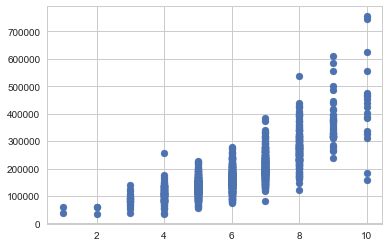

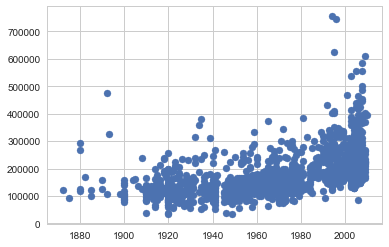

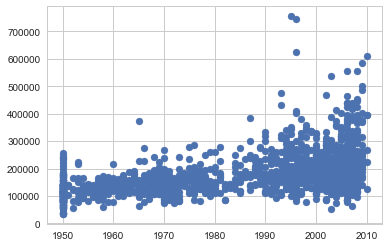

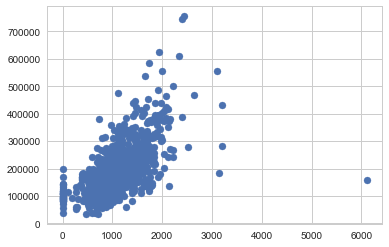

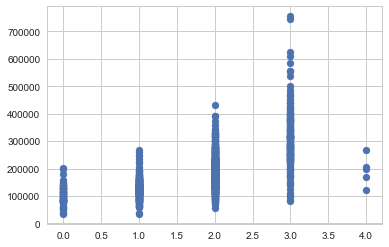

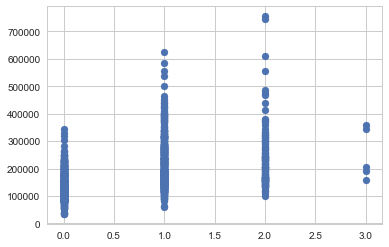

In [13]:
'''
From Lasso Regression, we find below parameters have significant impact on SalePrice.
OverallQual, YearBuilt, YearRemodAdd, TotalBsmtSF, GarageCars, Fireplaces
'''

TotalBsmtSFMean = all_data['TotalBsmtSF'].mean()
all_data.loc[all_data['TotalBsmtSF'] == 0, 'TotalBsmtSF'] = np.round(TotalBsmtSFMean).astype(int)
all_data['TotalBsmtSF'] = np.log(all_data['TotalBsmtSF'])
print('Skewness of TotalBsmtSF after Log Transform : %f'% all_data['TotalBsmtSF'].skew())
print('Kurtosis of TotalBsmtSF after Log Transform : %f'% all_data['TotalBsmtSF'].kurt())

plt.scatter(y =train_data.SalePrice,x = train_data.OverallQual)
plt.show()
plt.scatter(y =train_data.SalePrice,x = train_data.YearBuilt)
plt.show()
plt.scatter(y =train_data.SalePrice,x = train_data.YearRemodAdd)
plt.show()
plt.scatter(y =train_data.SalePrice,x = train_data.TotalBsmtSF)
plt.show()
plt.scatter(y =train_data.SalePrice,x = train_data.GarageCars)
plt.show()
plt.scatter(y =train_data.SalePrice,x = train_data.Fireplaces)
plt.show()

In [24]:
num_features = all_data.loc[:,['OverallQual', 'GarageCars', 'YearBuilt',
                              'TotalBsmtSF', 'YearRemodAdd','Fireplaces']]

train_data_features = num_features[:num_train_rows]
test_data_features = num_features[num_train_rows:]

from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree=2)
X_poly = poly_reg.fit_transform(train_data_features)

from sklearn.cross_validation import train_test_split
X_train , X_test, y_train, y_test = train_test_split(X_poly, target, test_size=0.4, random_state=0)

from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

from sklearn import metrics
y_test_predict = lin_reg.predict(X_test)
print('MAE',metrics.mean_absolute_error(y_test, y_test_predict))
print('MSE',metrics.mean_squared_error(y_test, y_test_predict))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_test, y_test_predict)))
print('RMSLE',np.sqrt(metrics.mean_squared_log_error(y_test, y_test_predict)))

print("Accuracy --> ", lin_reg.score(X_test, y_test)*100)

MAE 0.34861383386359635
MSE 0.23727663636998161
RMSE 0.4871104970845749
RMSLE 0.03787448152908362
Accuracy -->  -57.11648418520821
